# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.13.3-epsilon-fu4.new.420.422.429.fix.438.441'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

### Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

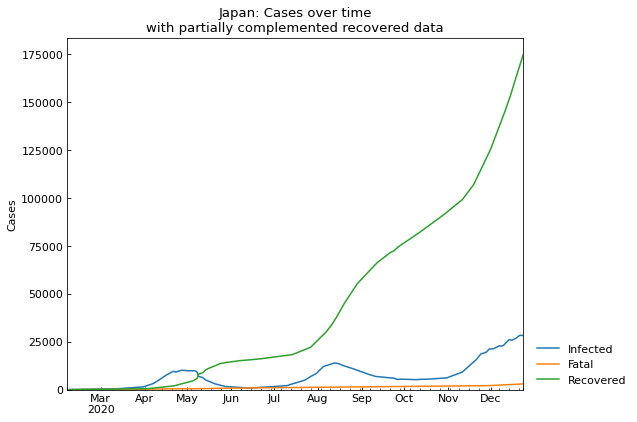

,Date,Infected,Fatal,Recovered
318,2020-12-20,27674,2873,165333
319,2020-12-21,28110,2900,167513
320,2020-12-22,28372,2944,169342
321,2020-12-23,28004,2994,172115
322,2020-12-24,28210,3050,174879


In [6]:
record_df = snl.records()
record_df.tail()

We can calculate the number of new cases with `Scenario.record_diff()` method.

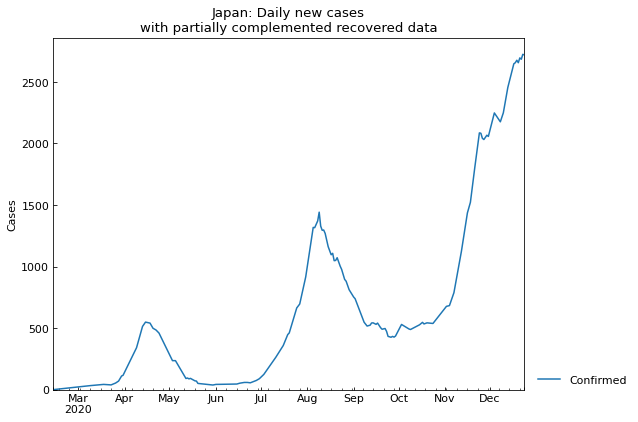

In [7]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

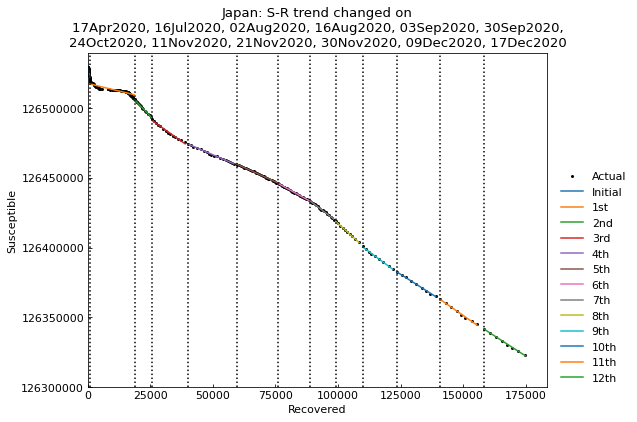

,Type,Start,End,Population
0th,Past,06Feb2020,16Apr2020,126529100
1st,Past,17Apr2020,15Jul2020,126529100
2nd,Past,16Jul2020,01Aug2020,126529100
3rd,Past,02Aug2020,15Aug2020,126529100
4th,Past,16Aug2020,02Sep2020,126529100
5th,Past,03Sep2020,29Sep2020,126529100
6th,Past,30Sep2020,23Oct2020,126529100
7th,Past,24Oct2020,10Nov2020,126529100
8th,Past,11Nov2020,20Nov2020,126529100
9th,Past,21Nov2020,29Nov2020,126529100


In [8]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [9]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 9th phase (06Feb2020 - 16Apr2020): finished 2639 trials in 3 min  1 sec


	 1st phase (11Nov2020 - 20Nov2020): finished 1331 trials in 1 min  0 sec

	 6th phase (24Oct2020 - 10Nov2020): finished 2980 trials in 3 min  0 sec

	11th phase (02Aug2020 - 15Aug2020): finished 3044 trials in 3 min  0 sec

	 5th phase (30Sep2020 - 23Oct2020): finished 3029 trials in 3 min  0 sec

	 0th phase (16Aug2020 - 02Sep2020): finished  290 trials in 0 min 10 sec

	 2nd phase (03Sep2020 - 29Sep2020): finished  527 trials in 0 min 20 sec

	 7th phase (17Dec2020 - 24Dec2020): finished  569 trials in 0 min 20 sec

	 8th phase (21Nov2020 - 29Nov2020): finished  524 trials in 0 min 20 sec

	12th phase (30Nov2020 - 08Dec2020): finished  237 trials in 0 min 10 sec

	10th phase (17Apr2020 - 15Jul2020): finished 2851 trials in 3 min  0 sec

	 3rd phase (16Jul2020 - 01Aug2020): finished  868 trials in 0 min 40 sec

	 4th phase (09Dec2020 - 16Dec2020): finished 1651 trials in 1 min 20 sec

Completed optimization. Total: 7 min 23 sec


In [10]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],1/gamma [day],alpha1 [-],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,5.00,0.017916,0.000149,0.034414,0.006616,480,2242,50,0.018,9,0.258609,2639,3 min 1 sec
1st,Past,17Apr2020,15Jul2020,126529100,SIR-F,0.54,0.083129,0.000159,0.010897,0.018396,480,2098,18,0.083,30,0.354543,2851,3 min 0 sec
2nd,Past,16Jul2020,01Aug2020,126529100,SIR-F,1.94,0.000344,0.000079,0.047556,0.024392,480,4209,13,0.000,7,0.026211,868,0 min 40 sec
3rd,Past,02Aug2020,15Aug2020,126529100,SIR-F,1.50,0.000173,0.000096,0.034042,0.022636,480,3484,14,0.000,9,0.050961,3044,3 min 0 sec
4th,Past,16Aug2020,02Sep2020,126529100,SIR-F,0.76,0.003344,0.000327,0.026373,0.034188,480,1020,9,0.003,12,0.022422,290,0 min 10 sec
5th,Past,03Sep2020,29Sep2020,126529100,SIR-F,0.80,0.000234,0.000453,0.025834,0.031888,480,736,10,0.000,12,0.027875,527,0 min 20 sec
6th,Past,30Sep2020,23Oct2020,126529100,SIR-F,0.99,0.000756,0.000346,0.032382,0.032320,480,963,10,0.001,10,0.012404,3029,3 min 0 sec
7th,Past,24Oct2020,10Nov2020,126529100,SIR-F,1.29,0.002706,0.000267,0.038483,0.029526,480,1249,11,0.003,8,0.022350,2980,3 min 0 sec
8th,Past,11Nov2020,20Nov2020,126529100,SIR-F,1.64,0.000828,0.000226,0.046814,0.028233,480,1476,11,0.001,7,0.013243,1331,1 min 0 sec
9th,Past,21Nov2020,29Nov2020,126529100,SIR-F,1.43,0.000936,0.000256,0.039190,0.027082,480,1304,12,0.001,8,0.020567,524,0 min 20 sec


### Accuracy of estimation

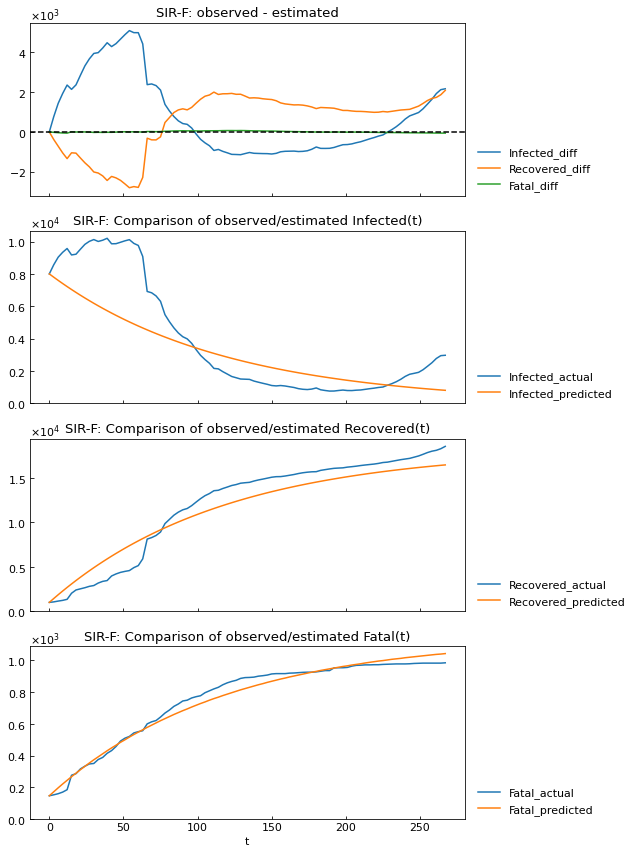

In [11]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [12]:
snl.get("Rt", phase="4th")

0.76

### Show parameter history

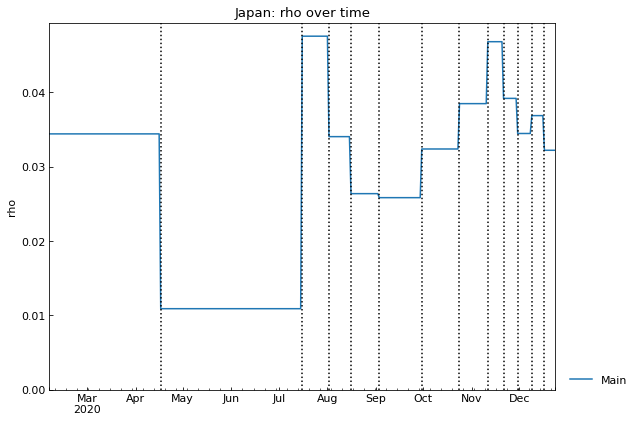

In [13]:
_ = snl.history(target="rho")

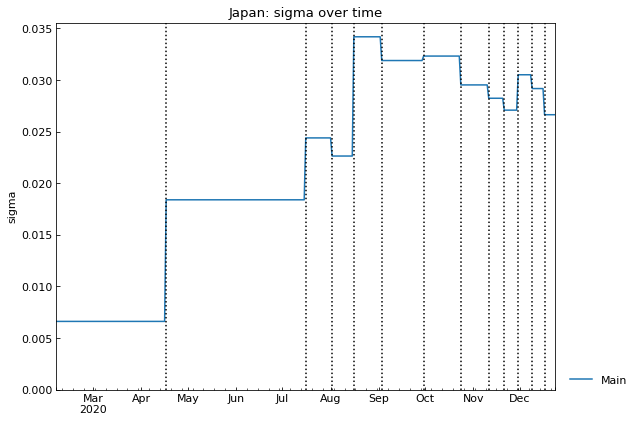

In [14]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

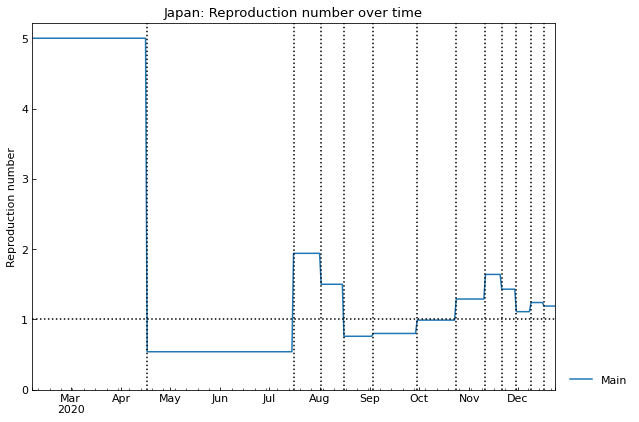

In [15]:
_ = snl.history(target="Rt")

### Simulate the number of cases

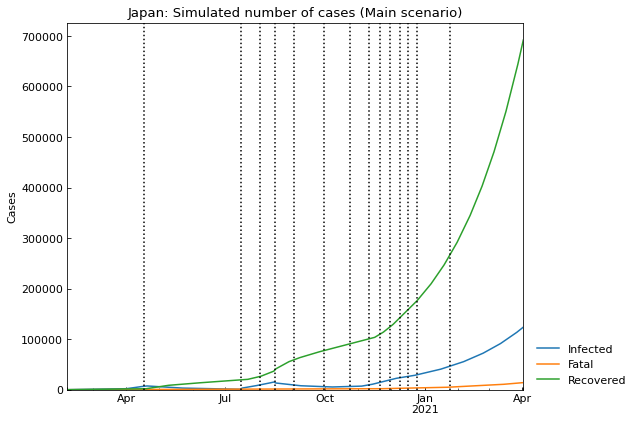

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,783441,13199,116836,653406
418,2021-03-30,794742,13397,118533,662812
419,2021-03-31,806206,13598,120254,672354
420,2021-04-01,817835,13802,121999,682034
421,2021-04-02,829632,14009,123768,691855


In [16]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [17]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.02663866037965955

In [18]:
sigma_new = sigma_current * 2
sigma_new

0.0532773207593191

In [19]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  16Apr2020   126529100  SIR-F  5.00   
         1st      Past  17Apr2020  15Jul2020   126529100  SIR-F  0.54   
         2nd      Past  16Jul2020  01Aug2020   126529100  SIR-F  1.94   
         3rd      Past  02Aug2020  15Aug2020   126529100  SIR-F  1.50   
         4th      Past  16Aug2020  02Sep2020   126529100  SIR-F  0.76   
         5th      Past  03Sep2020  29Sep2020   126529100  SIR-F  0.80   
         6th      Past  30Sep2020  23Oct2020   126529100  SIR-F  0.99   
         7th      Past  24Oct2020  10Nov2020   126529100  SIR-F  1.29   
         8th      Past  11Nov2020  20Nov2020   126529100  SIR-F  1.64   
         9th      Past  21Nov2020  29Nov2020   126529100  SIR-F  1.43   
         10th     Past  30Nov2020  08Dec2020   126529100  SIR-F  1.11   
         11th     Past  09Dec2020  16Dec2020   126529100  SIR-F  1.24   
         12th     Past  17Dec2020  24Dec2020   126529100  SIR-F  1.19   
         13th   Future  25Dec2020  23Jan2021   126529100  SIR-F  1.19   
         14th   Future  24Jan2021  01Apr2021   126529100  SIR-F  1.19   
Medicine 0th      Past  06Feb2020  16Apr2020   126529100  SIR-F  5.00   
         1st      Past  17Apr2020  15Jul2020   126529100  SIR-F  0.54   
         2nd      Past  16Jul2020  01Aug2020   126529100  SIR-F  1.94   
         3rd      Past  02Aug2020  15Aug2020   126529100  SIR-F  1.50   
         4th      Past  16Aug2020  02Sep2020   126529100  SIR-F  0.76   
         5th      Past  03Sep2020  29Sep2020   126529100  SIR-F  0.80   
         6th      Past  30Sep2020  23Oct2020   126529100  SIR-F  0.99   
         7th      Past  24Oct2020  10Nov2020   126529100  SIR-F  1.29   
         8th      Past  11Nov2020  20Nov2020   126529100  SIR-F  1.64   
         9th      Past  21Nov2020  29Nov2020   126529100  SIR-F  1.43   
         10th     Past  30Nov2020  08Dec2020   126529100  SIR-F  1.11   
         11th     Past  09Dec2020  16Dec2020   126529100  SIR-F  1.24   
         12th     Past  17Dec2020  24Dec2020   126529100  SIR-F  1.19   
         13th   Future  25Dec2020  23Jan2021   126529100  SIR-F  1.19   
         14th   Future  24Jan2021  01Apr2021   126529100  SIR-F  0.59   

                   theta     kappa       rho     sigma  tau  1/alpha2 [day]  \
Scenario Phase                                                                
Main     0th    0.017916  0.000149  0.034414  0.006616  480            2242   
         1st    0.083129  0.000159  0.010897  0.018396  480            2098   
         2nd    0.000344  0.000079  0.047556  0.024392  480            4209   
         3rd    0.000173  0.000096  0.034042  0.022636  480            3484   
         4th    0.003344  0.000327  0.026373  0.034188  480            1020   
         5th    0.000234  0.000453  0.025834  0.031888  480             736   
         6th    0.000756  0.000346  0.032382  0.032320  480             963   
         7th    0.002706  0.000267  0.038483  0.029526  480            1249   
         8th    0.000828  0.000226  0.046814  0.028233  480            1476   
         9th    0.000936  0.000256  0.039190  0.027082  480            1304   
         10th   0.003342  0.000327  0.034466  0.030510  480            1020   
         11th   0.000305  0.000530  0.036871  0.029172  480             629   
         12th   0.016303  0.000040  0.032208  0.026639  480            8408   
         13th   0.016303  0.000040  0.032208  0.026639  480            8408   
         14th   0.016303  0.000040  0.032208  0.026639  480            8408   
Medicine 0th    0.017916  0.000149  0.034414  0.006616  480            2242   
         1st    0.083129  0.000159  0.010897  0.018396  480            2098   
         2nd    0.000344  0.000079  0.047556  0.024392  480            4209   
         3rd    0.000173  0.000096  0.034042  0.022636  480            3484   
         4th    0.0033

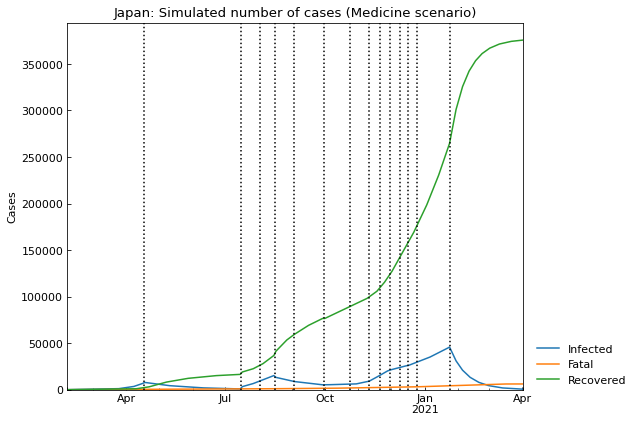

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,382176,6161,710,375305
418,2021-03-30,382242,6162,665,375415
419,2021-03-31,382303,6163,623,375517
420,2021-04-01,382362,6164,584,375614
421,2021-04-02,382416,6165,547,375704


In [20]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [21]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,14th_Rt
Main,123768,02Apr2021,829632,123768,14009,1.19
Medicine,45813,24Jan2021,382416,547,6165,0.59


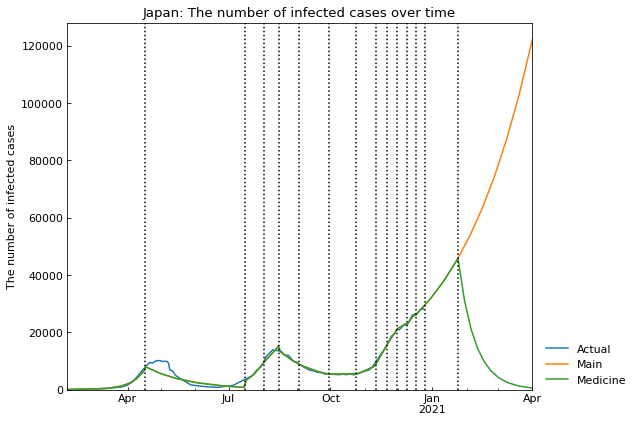

In [22]:
_ = snl.history(target="Infected")

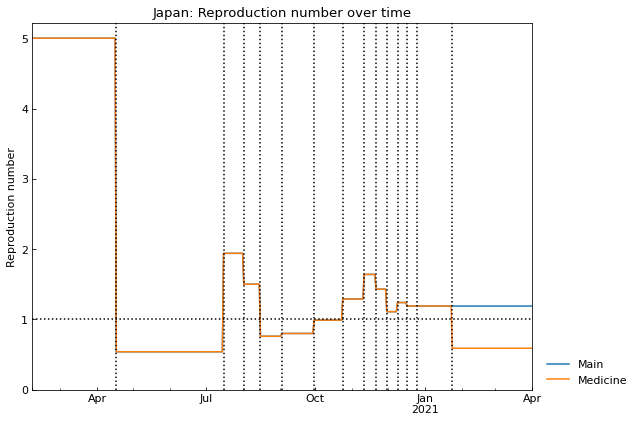

In [23]:
_ = snl.history(target="Rt")

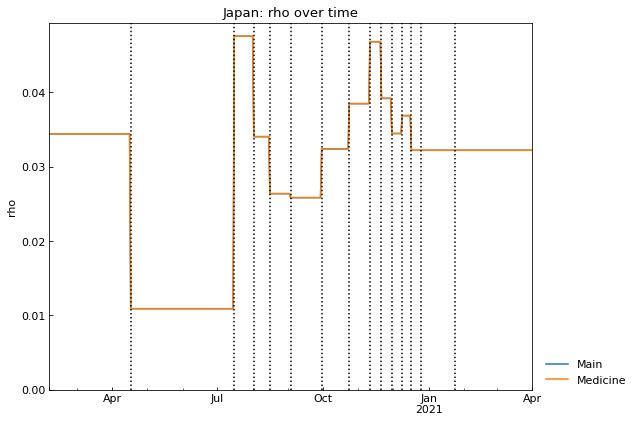

In [24]:
_ = snl.history(target="rho")

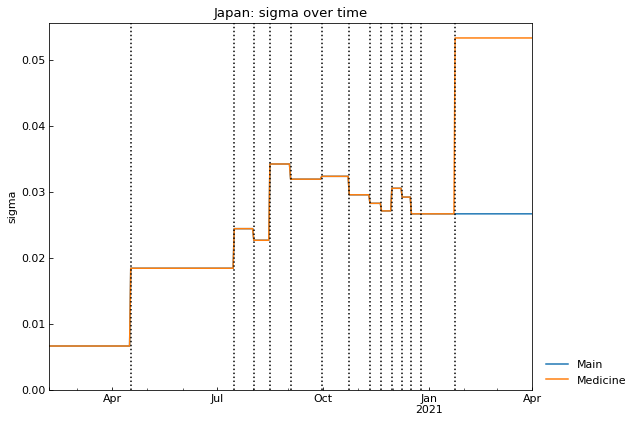

In [25]:
_ = snl.history(target="sigma")

Notes on the history of $\sigma$ value in japan (last updated: 18Dec2020):  
In Japan, we experienced two waves and we are in third wave. In the first wave (Apr - May), recovery period was too long because collapse of the medical care system occurred and no medicines were found.

Sigma values: the first wave < the second wave > the third wave

However, in the second wave (Jul - Oct), recovery period appears short because we have some effective medicines (not approved, in clinical study), yonger people (people un-associated to sever diseases) were infected.

In the third wave (Nov - ), older people tend to be infected and we are facing with medical collapse at this time...

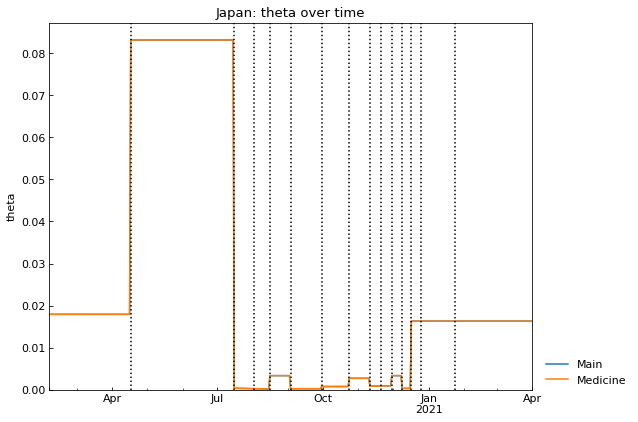

In [26]:
_ = snl.history(target="theta")

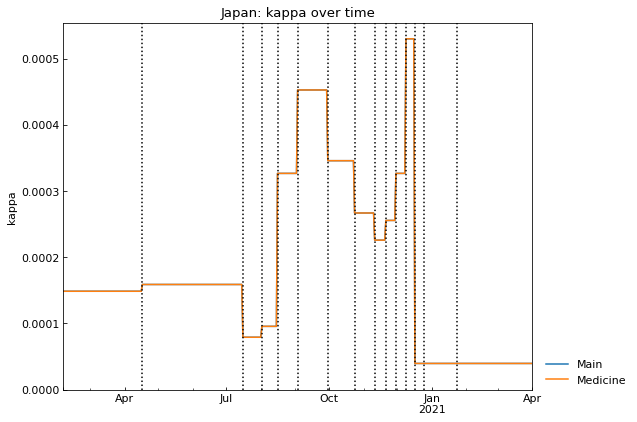

In [27]:
_ = snl.history(target="kappa")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

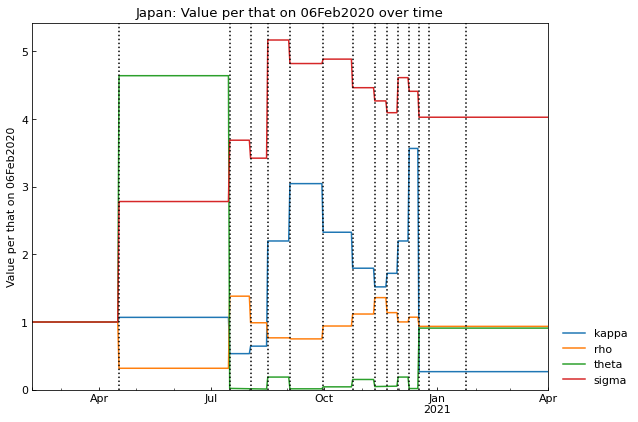

In [28]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [29]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 9th phase (06Feb2020 - 16Apr2020): finished 2585 trials in 3 min  1 sec


	 1st phase (11Nov2020 - 20Nov2020): finished 1310 trials in 1 min  0 sec

	11th phase (02Aug2020 - 15Aug2020): finished 2888 trials in 3 min  0 sec

	 5th phase (30Sep2020 - 23Oct2020): finished 2885 trials in 3 min  0 sec

	 6th phase (24Oct2020 - 10Nov2020): finished 2908 trials in 3 min  0 sec

	 0th phase (16Aug2020 - 02Sep2020): finished  290 trials in 0 min 10 sec

	 2nd phase (03Sep2020 - 29Sep2020): finished  539 trials in 0 min 20 sec

	 7th phase (17Dec2020 - 24Dec2020): finished  521 trials in 0 min 20 sec

	 8th phase (21Nov2020 - 29Nov2020): finished  516 trials in 0 min 20 sec

	12th phase (30Nov2020 - 08Dec2020): finished  279 trials in 0 min 10 sec

	10th phase (17Apr2020 - 15Jul2020): finished 2816 trials in 3 min  1 sec

	 3rd phase (16Jul2020 - 01Aug2020): finished  764 trials in 0 min 30 sec

	 4th phase (09Dec2020 - 16Dec2020): finished 1772 trials in 1 min 20 sec

Completed optimization. Total: 7 min 23 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 2nd phase (16Aug2020 - 24Dec2020): finished 9525 trials in 3 min  0 sec

Completed optimization. Total: 3 min  0 sec


In [30]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  16Apr2020  SIR-F  5.00  0.017916  0.000149   
              1st    17Apr2020  15Jul2020  SIR-F  0.54  0.083129  0.000159   
              2nd    16Jul2020  01Aug2020  SIR-F  1.94  0.000344  0.000079   
              3rd    02Aug2020  15Aug2020  SIR-F  1.50  0.000173  0.000096   
              4th    16Aug2020  02Sep2020  SIR-F  0.76  0.003344  0.000327   
              5th    03Sep2020  29Sep2020  SIR-F  0.80  0.000234  0.000453   
              6th    30Sep2020  23Oct2020  SIR-F  0.99  0.000756  0.000346   
              7th    24Oct2020  10Nov2020  SIR-F  1.29  0.002706  0.000267   
              8th    11Nov2020  20Nov2020  SIR-F  1.64  0.000828  0.000226   
              9th    21Nov2020  29Nov2020  SIR-F  1.43  0.000936  0.000256   
              10th   30Nov2020  08Dec2020  SIR-F  1.11  0.003342  0.000327   
              11th   09Dec2020  16Dec2020  SIR-F  1.24  0.000305  0.000530   
              12th   17Dec2020  24Dec2020  SIR-F  1.19  0.016303  0.000040   
Retrospective 0th    06Feb2020  16Apr2020  SIR-F  5.00  0.017916  0.000149   
              1st    17Apr2020  15Jul2020  SIR-F  0.54  0.083129  0.000159   
              2nd    16Jul2020  01Aug2020  SIR-F  1.94  0.000344  0.000079   
              3rd    02Aug2020  15Aug2020  SIR-F  1.50  0.000173  0.000096   
              4th    16Aug2020  24Dec2020  SIR-F  1.50  0.000173  0.000096   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.034414  0.006616  0.258609    2585  3 min  1 sec  
              1st    0.010897  0.018396  0.354543    2816  3 min  1 sec  
              2nd    0.047556  0.024392  0.026211     764  0 min 30 sec  
              3rd    0.034042  0.022636  0.050961    2888  3 min  0 sec  
              4th    0.026373  0.034188  0.022422     290  0 min 10 sec  
              5th    0.025834  0.031888  0.027875     539  0 min 20 sec  
              6th    0.032382  0.032320  0.012404    2885  3 min  0 sec  
              7th    0.038483  0.029526  0.022350    2908  3 min  0 sec  
              8th    0.046814  0.028233  0.013243    1310  1 min  0 sec  
              9th    0.039190  0.027082  0.020567     516  0 min 20 sec  
              10th   0.034466  0.030510  0.011070     279  0 min 10 sec  
              11th   0.036871  0.029172  0.010384    1772  1 min 20 sec  
              12th   0.032208  0.026639  0.008826     521  0 min 20 sec  
Retrospective 0th    0.034414  0.006616  0.258609    2585  3 min  1 sec  
              1st    0.010897  0.018396  0.354543    2816  3 min  1 sec  
              2nd    0.047556  0.024392  0.026211     764  0 min 30 sec  
              3rd    0.034042  0.022636  0.050961    2888  3 min  0 sec  
              4th    0.034042  0.022636  1.791963    9525  3 min  0 sec

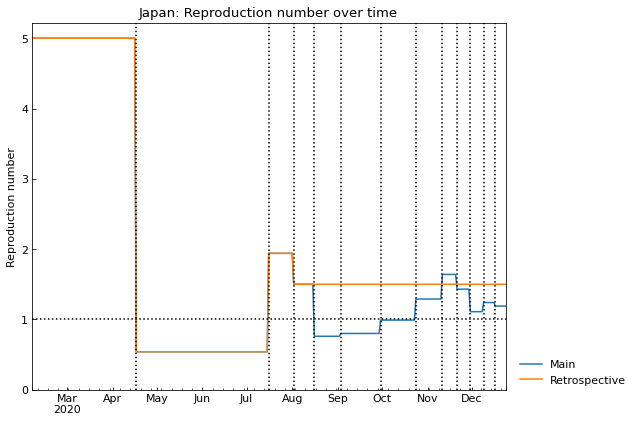

In [31]:
# History of reproduction number
_ = snl_retro.history("Rt")

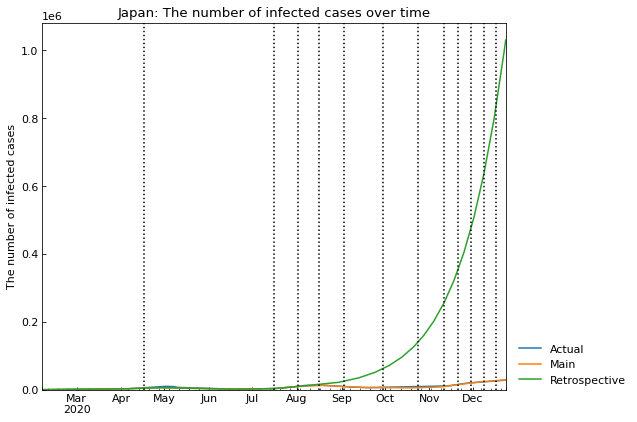

In [32]:
# History of Infected
_ = snl_retro.history("Infected")

In [33]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 25Dec2020,Infected on 25Dec2020,Fatal on 25Dec2020,4th_Rt,5th_Rt,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt
Main,29370,25Dec2020,208475,29370,3114,0.76,0.8,0.99,1.29,1.64,1.43,1.11,1.24,1.19
Retrospective,1062144,25Dec2020,3300050,1062144,10891,1.50,-,-,-,-,-,-,-,-
